## Building 3-layer neural network from numpy
Let’s start by importing some libraires required for creating our neural network.

In [6]:
from __future__ import print_function
import numpy as np ## Fr numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. let's create a mian class layer which can do a forward pass .*forward()* and backward pass .*backward()*.

In [8]:
class Layer:
    # A building block. Each layer is capable of performing two things:
    # - process inpput to get output 
    # output = layer.forward(input)
    
    # - propagate gradients through itself:
    # grad_input = layer.backward(input, gradoutput)
    
    # Some layers also have learnable parameters which they update 
    # during layer.backward.
    
    def __init__(self):
        # here we can initialize layer parameters (if any) 
        # and auxiliary stuff
        # A dummy layer does nothing
        pass
    
    def forward(self, input_):
        # Takes input data of shape [batch, input_units], 
        #return ouput data [batch, output_units]
        
        # A dummy layer just returns whatever it gets as input.
        return input_
    
    def backward(self, input_, grad_output):
        # Performs a backpropagation step through the layer, 
        # with respect to the given input.
        # To compute loss gradients w.r.t input, we need to apply 
        # chain rule (backprop):
        # d_loss/d_x = (d_loss/d_layer) * (d_layer/d_x)
        # luckily, we already receive d_loss/d_layer as input, 
        # so you only need to multiply it by d_layere/d_x.
        # If our layer has parameters (e.g. dense layer), 
        # we also need to update them here using d_loss/d_layer
        # The gradient of dummy layer is precisely grad_output, 
        # but we'll write it more explicity
        num_units = input_.shape[1]
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input) # chain rule 

## Active layer - with nonlinearity ReLU
This is the simplest layer you can get: it simply applies a nonlinarity to each element of your network
Definition:
$$ReLU(x) = \max(0,x)=\begin{cases}0, & \text{if}\ x<0\\x, & \text{if}\ x \geq 0\end{cases}$$
then:
$$\frac{\partial}{\partial x}ReLU(x) = \begin{cases}0, & \text{if}\ x<0\\1, & \text{if}\ x > 0\end{cases}$$

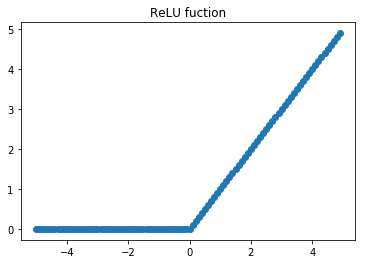

In [32]:
def relu(x):
    return np.maximum(0,x)
# graph
x_ = np.arange(-5,5,0.1)
y_ = relu(x_)
plt.scatter(x_, y_)
plt.title("ReLU fuction")
plt.show()

In [9]:
class ReLU(Layer):
    
    def __init__(self):
        # ReLu layer simply applies elementwise rectified linear unit
        # to all inputs.
        # We do not update parameters through ReLU.backward
        
        pass
    
    def forward(self, input_):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0, input_)
        return relu_forward
    
    def backward(self, input_, grad_output):
        # Compute gradient of loss w.r.t ReLU input
        relu_grad = input_ > 0
        return grad_output*relu_grad

## Dense layer
Now let's build somethign more complicate. Unlike nonlinearity, a dense layer actully has something to learn. <br>
A dense layer applies affine transformation. in a vectorized form, it can be described as:
$$f(\mathbf{X}) = \mathbf{W} . \mathbf{X} + \mathbf{b}$$
Where:<br>
- $\mathbf{X}$ is an object-feature matrix of shape [batch_size, num_features], <br>
- $\mathbf{W}$ is a weight matrix [num_features, num_outputs]<br>
- and $\mathbf{b}$ is a vector of num_outputs biases.


Both $\mathbf{W}$ and $\mathbf{b}$ are **initialized** *during layer creation* and **updated** each time *backward is called*. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster. Instead of initializing our weights with small numbers which are distributed randomly, we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

## Notes

In case of multilayer perceptron with L layers

$$ A_0 = X$$


$$Z_1 = W_1.A_0 + B_1\\
A_1 = g_1(Z_1)$$


$$Z_2 = W_2.A_1 + B_2\\
A_2 = g_2(Z_2)\\ ...$$

$$Z_{L-1} = W_{L-1}.A_{L-2} + B_{L-1}\\
A_{L-1} = g_{L-1}(Z_{L-1})$$


$$Z_L = W_L.A{L_1} + B_L\\
A_L = g_L(Z_L) = \hat{Y}$$

where at each layer $l,\ l = 1,...,L$, there exists
- $Z_l$: linear summator at $l$ layer
- $A_l$: activator at $l$ layer
- $B_l$: bias vector 
- $W_l$: weight matrix
- $g_l$: activator function
- input = $A_{l-1}$, output = $A_l$

Then according to backpropagation:

$$\sigma = \hat{Y} - Y = A_L - Y$$
**grad_weights** = $\displaystyle \frac{\partial \sigma}{\partial W_L} = \frac{\partial \sigma}{\partial A_L}\frac{\partial A_L}{\partial Z_L}\frac{\partial Z_L}{\partial W_L}$<br>
**grad_output** = $\displaystyle\frac{\partial \sigma}{\partial A_L}\frac{\partial A_L}{\partial Z_L}$<br>
**input** = $\displaystyle\frac{\partial Z_L}{\partial W_L} = A_{L-1}$<br>
so: **grad_weights** = **grad_output** * **input**

**grad_biases** = $\displaystyle \frac{\partial \sigma}{\partial W_L} = \frac{\partial \sigma}{\partial A_L}\frac{\partial A_L}{\partial Z_L}\frac{\partial Z_L}{\partial B_L}$ = **grad_output** * $\mathbb{1}$

**grad_input** = $\displaystyle\frac{\partial \sigma}{\partial A_{L-1}} = \frac{\partial \sigma}{\partial A_L}\frac{\partial A_L}{\partial Z_L}\frac{\partial Z_L}{\partial A_{L-1}}$ = **grad_output** * $\displaystyle\frac{\partial Z_L}{\partial A_{L-1}}$ = **grad_output** * $\displaystyle W_L$

In [10]:
class Dense(Layer):
    
    def __init__(self, input_units, output_units, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine 
        # transformation:
        # f(X) = W*X + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(
            loc=0.0, 
            scale=np.sqrt(2/(input_units+output_units)),
            size=(input_units, output_units)
        )
        self.biases = np.zeros(output_units)
    
    def forward(self, input_):
        # perform an affine transformation:
        # f(X) = W*X + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output_units]
        
        return np.dot(input_, self.weights) + self.biases
    
    def backward(self, input_, grad_output):
        # compute d_f/d_x = d_f/d_dense * d_dense/d_x
        # where d_dense/d_x = weights transposed
        # and d_f/d_dense = grad_output
        
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and bias (things to update)
        grad_weights = np.dot(input_.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input_.shape[0]
        
        assert grad_weights.shape == self.weights.shape\
               and grad_biases.shape == self.biases.shape
        
        # Here we perform a schochastic gradient descent step.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input     

## The loss function
Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits(a), you'll see:
$$loss = -\log\frac{e^{\alpha_{\text{correct}}}}{\sum_i{e^{\alpha_i}}}$$
If we take a closer look, we'll see that it can be written as:
$$loss = -\alpha_{\text{correct}}+\log\sum_i{e^{\alpha_i}}$$
It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:

- Better numerical stability
- Easier to get derivative rigt
- Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [11]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # compute crossentropy from logits, sized [batch, n_classes] 
    # and ids of correct answers
    
    logits_for_answers = \
            logits[np.arange(len(logits)), reference_answers]
    
    xentropy = - logits_for_answers + \
                 np.log(np.sum(np.exp(logits), axis=-1))
    
    return xentropy

$$\frac{\partial loss}{\partial\alpha_{\text{correct}}} = -\mathbb{1} + \frac{\partial}{\partial\alpha_{\text{correct}}}\log\sum_i{e^{\alpha_i}} = -\mathbb{1}+\frac{e^{\alpha_{\text{correct}}}}{\sum_i{e^{\alpha_i}}} = -\mathbb{1} + softmax(\boldsymbol{\alpha})$$

In [12]:
def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # compute crossentropy gradient from logits[batch, n_classes]
    # and ids of correct answers
    
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, 
                                                  keepdims=True)
    return (-ones_for_answers + softmax) / logits.shape[0]

## Full network
Now let's combine what we've just built into a working neural network. As I have told earlier, we are going to use MNIST data of handwritten digit for our example. Fortunately, Keras have it in the Numpy array format, so let's import it!

In [13]:
import keras
# keras is only used for loading data
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
        
    # loading
    (X_train, y_train), (X_test, y_test) = \
        keras.datasets.mnist.load_data()
    
    # each matrix of X is a array 28 x 28, each matrix element is
    # a numbeer in [1...255], indicating bright intensity
    # 0 = black, 255 = white, others = gray
    
    # each element of y is a class in [0...9]
    
    
    # normalising
    X_train = X_train.astype(float)/255.
    X_test = X_test.astype(float)/255.
    
    # we reserve the last 10.000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        # transform size batch x 28 x 28 to batch x 724
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
    
    return X_train, y_train, X_val, y_val, X_test, y_test 
        

/home/hung/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


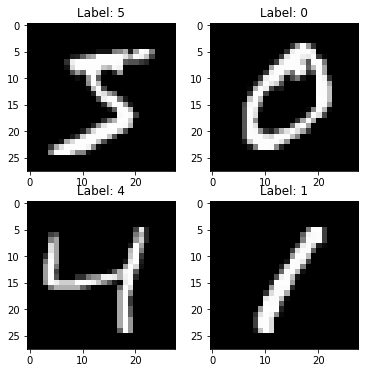

In [14]:
# load data (need to dowload )
X_train, y_train, X_val, y_val, X_test, y_test = \
    load_dataset(flatten=True)
# Look at some examples
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]), cmap='gray')

We'll define network as a list of laysers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [15]:
# net work with ReLU as active function

network = []
# fisrt hidden layer, dense, 724 inputs, 100 units, 100 outputs
# no active function
network.append(Dense(X_train.shape[1], 100))
# active layer
network.append(ReLU())
# second hidden layer, 100 inputs, 200 units, 200 outputs
network.append(Dense(100, 200))
# active layer
network.append(ReLU())
# output layer, 200 inputs, 10 units, 10 outputs
network.append(Dense(200, 10))

In [16]:
network

In [17]:
def forward(network, X):
    # compute activations for all network layers 
    # by applying them sequentially.
    # X: beginning in put
    # Return a list of activations for each layers.
        
    activations = []
    input_ = X
    
    # looping through each layer
    for layer in network:
        activations.append(layer.forward(input_))
        # updating input to last layer output
        input_ = activations[-1]
        
    assert len(activations) == len(network)
    
    return activations

def predict(network, X):
    # compute network predicstions.
    # X: beginning in put
    # Return indices of largest logit probability
    
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

def train(network, X, y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers 
    # have already made one gradient step
    
    # Get the layer activations
    layer_activations = forward(network, X)
    
    # layer_input[i] is an input for network[i]
    layer_inputs = [X] + layer_activations
    
    logits = layer_activations[-1]
    
    # compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
    # propagate gradients through the network
    # reverse propagation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        # grad w.r.t. input, also weight updates
        loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)
        
    return np.mean(loss)


## Training loop

We split data into binibatches, feed each such minibatch into the network and update weights. This training is called mini-batch stochastic gradient descent.

In [18]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs)-batchsize+1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batchsize]
        else:
            excerpt = slice(start_idx, start_idx+batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 4
Train accuracy 0.9893
Validation accuracy 0.9766


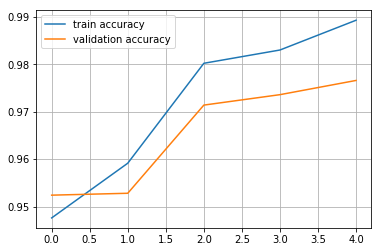

In [19]:
# Remember to reset network before launching this cell
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(5):
    for x_batch, y_batch in \
        iterate_minibatches(
            inputs=X_train, 
            targets=y_train,
            batchsize=32,
            shuffle=True
        ):
        train(network, x_batch, y_batch)
        
    train_log.append(np.mean(predict(network, X_train)==y_train))
    val_log.append(np.mean(predict(network, X_val)==y_val))
        
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy", train_log[-1])
    print("Validation accuracy", val_log[-1])
    
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='validation accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

As we can see we have successfully train a MLP which was purely written in Numpy with high validation accuracy.

In [88]:
# test accuracy
np.mean(predict(network, X_test)==y_test)
# on 35 epoches is 0.9837

0.9837

Prediction: 8 
Sample:


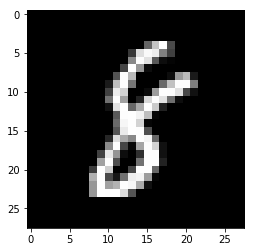

In [80]:
# Test model
xtest = X_test[-100].reshape([1,784])
plt.imshow(xtest[0].reshape([28,28]), cmap='gray')
print("Prediction:", predict(network, xtest)[0], "\nSample:")

In [81]:
# fail in test
indices = []
for i in range(0,len(X_test)):
    xtest = X_test[i].reshape([1,784])
    label = y_test[i]
    pred = predict(network, xtest)[0]
    if  pred != label:
        indices.append(i)
print(indices)
#         plt.imshow(xtest[0].reshape([28,28]), cmap='gray')
#         print("Index:",i,"\nLabel:", label, "\nPrediction:", pred, "\nSample:")
#         break

[8, 247, 321, 340, 445, 449, 495, 582, 684, 720, 740, 877, 900, 947, 951, 1014, 1039, 1044, 1112, 1178, 1181, 1194, 1224, 1226, 1247, 1319, 1328, 1393, 1395, 1414, 1494, 1500, 1530, 1671, 1681, 1717, 1790, 1850, 1878, 1901, 1952, 1984, 1987, 2018, 2035, 2053, 2070, 2098, 2109, 2118, 2130, 2135, 2272, 2293, 2387, 2414, 2447, 2488, 2607, 2648, 2654, 2810, 2877, 2896, 2915, 2921, 2939, 2995, 3073, 3117, 3225, 3251, 3422, 3441, 3474, 3490, 3503, 3520, 3549, 3558, 3681, 3776, 3796, 3808, 3893, 3906, 3941, 4065, 4078, 4123, 4140, 4163, 4176, 4199, 4201, 4248, 4300, 4344, 4425, 4497, 4536, 4551, 4567, 4601, 4671, 4731, 4740, 4751, 4807, 4823, 4860, 4876, 4880, 4966, 5046, 5457, 5600, 5642, 5676, 5734, 5936, 5937, 5955, 5972, 5973, 5997, 6023, 6059, 6166, 6555, 6559, 6560, 6574, 6597, 6625, 6755, 6783, 6926, 7216, 7434, 8062, 8094, 8246, 8255, 8273, 8311, 8325, 8339, 8527, 9009, 9015, 9024, 9587, 9634, 9664, 9669, 9679, 9729, 9745, 9749, 9755, 9768, 9770, 9839, 9858, 9944]


In [82]:
len(indices) 

166

In [83]:
len(X_test)

10000

In [84]:
(len(X_test)-len(indices))/float(len(X_test)) # 30 epoches is 0.9834

0.9834

In [85]:
X_train.shape

(50000, 784)

In [86]:
X_val.shape

(10000, 784)

## Active layer with sigmoid function

Sigmoid fuction:
$$\sigma(x)=\frac{e^x}{e^x+1}=\frac{1}{1+e^{-x}}$$
$$\frac{\partial}{\partial x}\sigma(x) = \frac{e^{-x}}{(1+e^{-x})^2}=\frac{(1+e^{-x})-1}{(1+e^{-x})^2}=\frac{1}{1+e^{-x}}-\frac{1}{(1+e^{-x})^2} = \sigma(x)[1-\sigma(x)]$$

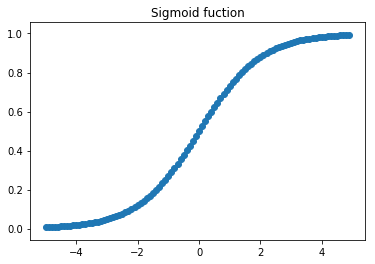

In [33]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
# graph
x_ = np.arange(-5,5,0.1)
y_ = sigmoid(x_)
plt.scatter(x_, y_)
plt.title("Sigmoid fuction")
plt.show()

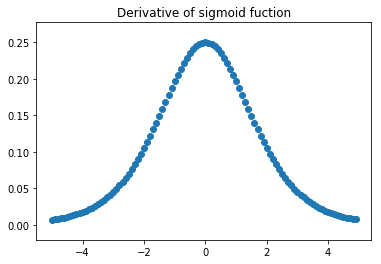

In [41]:
ds_ = sigmoid(x_)*(1-sigmoid(x_))
plt.scatter(x_, ds_)
plt.title("Derivative of sigmoid fuction")
plt.show()

In [21]:
class Sigmoid(Layer):
    
    def __init__(self):
        # Sigmoid layer applies sigmoid function to each input
        # We do not update parameters through Sigmoid.backward
        pass
    
    def forward(self, input_):
        # Apply sigmoid function to [batch, input_units] matrix
        sigmoid_forward = sigmoid(input_)
        return sigmoid_forward
    
    def backward(self, input_, grad_output):
        # Compute gradient of loss w.r.t sigmoid input
        sigmoid_ = sigmoid(input_)
        sigmoid_grad = sigmoid_ * (1-sigmoid_)
        return grad_output*sigmoid_grad

In [22]:
# net work with sigmoid as active function

# Input --> [Dense()+Sigmoid(), 100 units] --> [Dense()+Sigmoid(), 200 units] --> [Dense(), 10 units] --> Softmax()

network = []
# fisrt hidden layer, dense, 724 inputs, 100 units, 100 outputs
# no active function
network.append(Dense(X_train.shape[1], 100))
# active layer
network.append(Sigmoid())
# second hidden layer, 100 inputs, 200 units, 200 outputs
network.append(Dense(100, 200))
# active layer
network.append(Sigmoid())
# output layer, 200 inputs, 10 units, 10 outputs
network.append(Dense(200, 10))

In [23]:
network

Epoch 4
Train accuracy 0.94272
Validation accuracy 0.9457


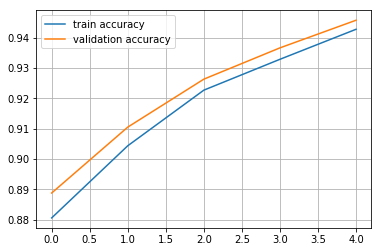

In [24]:
# training
# Remember to reset network before launching this cell

from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(5):
    for x_batch, y_batch in \
        iterate_minibatches(
            inputs=X_train, 
            targets=y_train,
            batchsize=32,
            shuffle=True
        ):
        train(network, x_batch, y_batch)
        
    train_log.append(np.mean(predict(network, X_train)==y_train))
    val_log.append(np.mean(predict(network, X_val)==y_val))
        
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy", train_log[-1])
    print("Validation accuracy", val_log[-1])
    
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='validation accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Prediction: 8 
Sample:


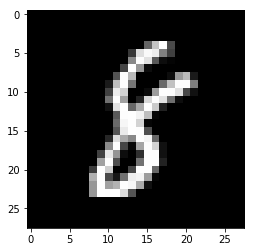

In [25]:
# Test model
xtest = X_test[-100].reshape([1,784])
plt.imshow(xtest[0].reshape([28,28]), cmap='gray')
print("Prediction:", predict(network, xtest)[0], "\nSample:")

## Active layer with tanh function
Definition:
$$\tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$
$$\frac{\partial}{\partial x}\tanh(x)=1-\tanh^2(x)$$

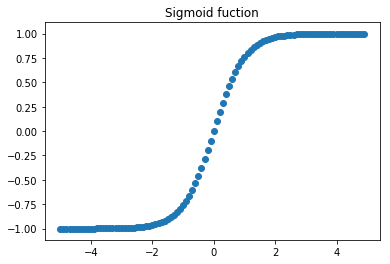

In [37]:
# graph
x_ = np.arange(-5,5,0.1)
y_ = np.tanh(x_)
plt.scatter(x_, y_)
plt.title("Tanh fuction")
plt.show()

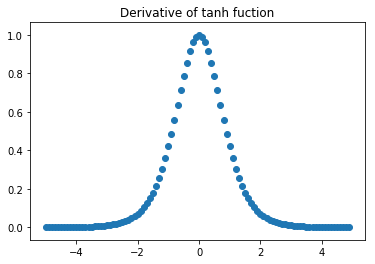

In [39]:
dy_ = 1-np.tanh(x_)**2
plt.scatter(x_, dy_)
plt.title("Derivative of tanh fuction")
plt.show()

In [42]:
class Tanh(Layer):
    
    def __init__(self):
        # Tanh layer applies tanh function to each input
        # We do not update parameters through Tanh.backward
        pass
    
    def forward(self, input_):
        # Apply tanh function to [batch, input_units] matrix
        return np.tanh(input_)
    
    def backward(self, input_, grad_output):
        # Compute gradient of loss w.r.t tanh input
        tanh_grad = 1 - np.tanh(input_)**2
        return grad_output*tanh_grad

In [49]:
# net work with sigmoid, tanh as active functions

# Input --> [Dense()+Tanh(), 100 units] --> [Dense()+Sigmoid(), 200 units] --> [Dense(), 10 units] --> Softmax()

network = []
# fisrt hidden layer, dense, 724 inputs, 100 units, 100 outputs
# no active function
network.append(Dense(X_train.shape[1], 100))
# active layer
network.append(Tanh())
# second hidden layer, 100 inputs, 200 units, 200 outputs
network.append(Dense(100, 200))
# active layer
network.append(Sigmoid())
# output layer, 200 inputs, 10 units, 10 outputs
network.append(Dense(200, 10))

In [44]:
network

Epoch 4
Train accuracy 0.97306
Validation accuracy 0.9684


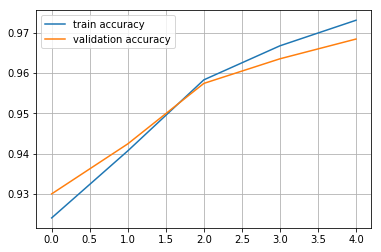

In [50]:
# training
# Remember to reset network before launching this cell

from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(5):
    for x_batch, y_batch in \
        iterate_minibatches(
            inputs=X_train, 
            targets=y_train,
            batchsize=32,
            shuffle=True
        ):
        train(network, x_batch, y_batch)
        
    train_log.append(np.mean(predict(network, X_train)==y_train))
    val_log.append(np.mean(predict(network, X_val)==y_val))
        
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy", train_log[-1])
    print("Validation accuracy", val_log[-1])
    
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='validation accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Model accuracy: 0.964
Sample test 
Label: 5 
Prediction: 6 
Image:


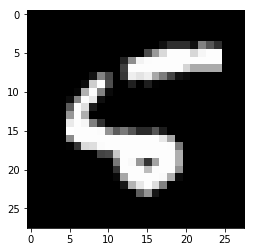

In [55]:
# test accuracy
print("Model accuracy:", np.mean(predict(network, X_test)==y_test))

# Test model
idd = 8
xtest = X_test[idd].reshape([1,784])
plt.imshow(xtest[0].reshape([28,28]), cmap='gray')
print("Sample test","\nLabel:", y_test[idd],"\nPrediction:", predict(network, xtest)[0], "\nImage:")

## Conclusion
For MNIST problem, ReLU > Tanh > Sigmoid on convergence time.


In [56]:
# net work with sigmoid, tanh as active functions

# Input --> [Dense()+Tanh(), 100 units] --> [Dense()+Tanh(), 200 units] --> [Dense(), 10 units] --> Softmax()

network = []
# fisrt hidden layer, dense, 724 inputs, 100 units, 100 outputs
# no active function
network.append(Dense(X_train.shape[1], 100))
# active layer
network.append(Tanh())
# second hidden layer, 100 inputs, 200 units, 200 outputs
network.append(Dense(100, 200))
# active layer
network.append(Tanh())
# output layer, 200 inputs, 10 units, 10 outputs
network.append(Dense(200, 10))

In [47]:
network

Epoch 4
Train accuracy 0.98188
Validation accuracy 0.9708


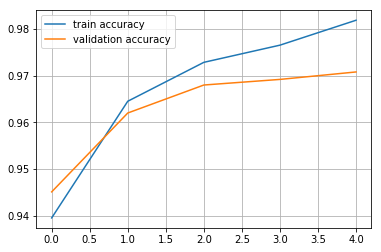

In [57]:
# training
# Remember to reset network before launching this cell

from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(5):
    for x_batch, y_batch in \
        iterate_minibatches(
            inputs=X_train, 
            targets=y_train,
            batchsize=32,
            shuffle=True
        ):
        train(network, x_batch, y_batch)
        
    train_log.append(np.mean(predict(network, X_train)==y_train))
    val_log.append(np.mean(predict(network, X_val)==y_val))
        
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy", train_log[-1])
    print("Validation accuracy", val_log[-1])
    
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='validation accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Model accuracy: 0.9699
Sample test 
Label: 5 
Prediction: 6 
Image:


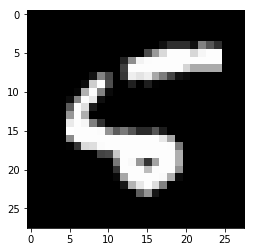

In [58]:
# test accuracy
print("Model accuracy:", np.mean(predict(network, X_test)==y_test))

# Test model
idd = 8
xtest = X_test[idd].reshape([1,784])
plt.imshow(xtest[0].reshape([28,28]), cmap='gray')
print("Sample test","\nLabel:", y_test[idd],"\nPrediction:", predict(network, xtest)[0], "\nImage:")

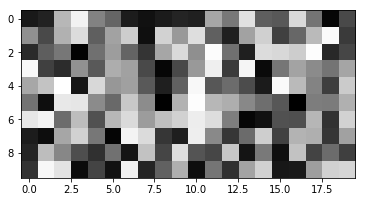

In [73]:
atv = forward(network, xtest)
plt.imshow(((atv[3].reshape([10, 20])+1)/2*255).astype(int), cmap='gray')
print("")